# Praca domowa 4

Autor: Paulina Przybyłek

## Wczytanie pakietów i opis pracy 

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
#!pip install category_encoders
import category_encoders as ce
#!pip install rdata
import rdata
import dalex as dx
import sklearn
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, KFold
from sklearn import preprocessing
from sklearn.metrics import balanced_accuracy_score, plot_precision_recall_curve, precision_score, recall_score, matthews_corrcoef
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline, make_pipeline
import warnings
warnings.filterwarnings('ignore')

Zadanie polega na przetestowaniu algorytmu SVM na dwóch zbiorach danych:
* apartments z R-owego pakietu DALEX
* dowolnego wybranego zbioru - (informacja o tym jaki to zbiór)

i sprawdzeniu jaki wpływ ma standaryzacja/skalowanie danych na na jakość tego algorytmu. Dodatkowo w celu polepszenia działania algorytmu wykonane ma zostać strojenie hiperparametrów.

## Zbiór I - apartments (DALEX)

### Wczytanie zbioru, krótka analiza i podział na zbiór treningowy i testowy

Zbiór **apartments** został pobrany z repozytorium pakietu.

In [0]:
parsed = rdata.parser.parse_file('apartments.rda')
converted = rdata.conversion.convert(parsed)
apartments = converted['apartments']

In [7]:
apartments.head()

,m2.price,construction.year,surface,floor,no.rooms,district
0,5897.0,1953.0,25.0,3,1.0,Srodmiescie
1,1818.0,1992.0,143.0,9,5.0,Bielany
2,3643.0,1937.0,56.0,1,2.0,Praga
3,3517.0,1995.0,93.0,7,3.0,Ochota
4,3013.0,1992.0,144.0,6,5.0,Mokotow


Jak widać mamy sześć kolumn, 5 numerycznych i 1 kategoryczną, przyjrzyjmy się jeszcze szegółom zbioru.

In [8]:
apartments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   m2.price           1000 non-null   float64 
 1   construction.year  1000 non-null   float64 
 2   surface            1000 non-null   float64 
 3   floor              1000 non-null   int64   
 4   no.rooms           1000 non-null   float64 
 5   district           1000 non-null   category
dtypes: category(1), float64(4), int64(1)
memory usage: 40.6 KB


Nie mamy brakujących wartości, a district uznajemy za zmienną celu (rozważamy klasyfikację), jednak musimy ją zakodować zanim przejdziemy do modelowania. Nie będziemy dalej przeprowadzać EDA, gdyż zadanie tego nie wymaga, dlatego przejdziemy od razu do zakodowania targetu i podziału danych na testowy i treningowy zbiór.

In [0]:
def dataPreparing(data, target):
  """
  Funkcja koduje target i zwraca podzielony zbiór na treningowy i testowy z wydzieleniem targetu.
  """
  # dzielimy zbiór na dwie części - z i bez kolumny targetu, target kodujemy z wykorzystaniem LabelEncoder
  le = preprocessing.LabelEncoder()
  y = np.array(data[target])
  y = le.fit_transform(y)
  X = data.drop([target],axis=1)
  # podział na zbiór treningowy i testowy
  return train_test_split(X, y, test_size=0.2, random_state=123)

data_train, data_test, target_train, target_test = dataPreparing(apartments, 'district')

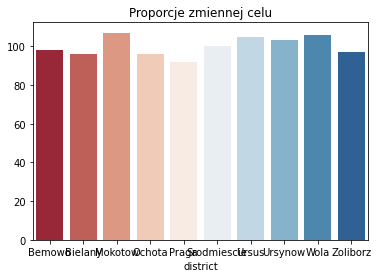

In [10]:
# zobaczmy czy zbiór jest zbalansowany
def targetPlot(data, target):
  pl = sns.countplot(x=target, data=data, palette='RdBu')
  pl.set_ylabel('')
  pl.set_title('Proporcje zmiennej celu')
  return pl

targetPlot(apartments, 'district')

Powyższy wykres został dodany, aby sprawdzić czy dane są zbalansowane czy też nie - jak widzimy są, dlatego możemy używać różnych miar nie martwiąc się o to czy dobrze działają na niezbalansowanych zbiorach.

Mamy kilka dzielnic warszawskich w zmiennej celu (dokładnie 10) i są one zakodowe od 0 do 9. Mając podzielony zbiór możemy teraz przejść do trenowania algorytmu.

### Modelowanie

Najpierw sprawdzimy jak sprawdza się algorytm przy defaultowych parametrach dla zbioru. Wybierzemy model SVC z pakietu sklearn.svm, który nie ma ustawionego skalowania i będziemy mogli zmieniać jądro. Potem zoptymalizujemy parametry modelu. Dodatkowo powtórzymy zabieg dla danych po skalowaniu. Wyniki porównamy przy wykorzystaniu zbalansowanego accuracy (które w tym przypadku będzie działać podobnie jak accuracy, gdyż zbiór jest zbalansowany).

In [11]:
# tworzymy funkcję pomocniczą badającą wpływ standaryzacji na wyniki
def examineTransformingInfluence(model, name, score):
    """
    Funkcja wykorzystuje kroswalidację oraz zwraca średni wynik oraz odchylenie standardowe dla zbioru treningowego bez 
    transformacji oraz dla zbioru po standaryzacji. Stosowaną miarę i algorytm do modelowania podajemy w argumentach funkcji.
    """
    standarizer = preprocessing.StandardScaler()
    standarizing_pipeline = make_pipeline(standarizer, model)
    CVscores_no_transform = cross_val_score(model, data_train, target_train, cv = KFold(5), scoring=score)
    CVscores_standarization = cross_val_score(standarizing_pipeline, data_train, target_train, cv = KFold(5), scoring=score)
    print(name + ":")
    print('Średnia wyników bez transformacji: {0:.4f}, odchylenie standardowe: {1:.4f}'.format(CVscores_no_transform.mean(), CVscores_no_transform.std()))
    print('Średnia wyników po standaryzacji: {0:.4f}, odchylenie standardowe: {1:.4f}'.format(CVscores_standarization.mean(), CVscores_standarization.std()))

# sprawdzimy różne jądra
svc_rbf = SVC(random_state = 0)
svc_linear = SVC(kernel = 'linear', random_state = 0)
svc_poly = SVC(kernel = 'poly', random_state = 0)
svc_sigmoid = SVC(kernel = 'sigmoid', random_state = 0)

# ustwiamy zbalansowane accuracy jako naszą miarę do podania funkcji
balanced_accuracy = sklearn.metrics.make_scorer(balanced_accuracy_score)

examineTransformingInfluence(svc_rbf, 'SVC with rbf kernel', balanced_accuracy)
examineTransformingInfluence(svc_linear, 'SVC with linear kernel', balanced_accuracy)
examineTransformingInfluence(svc_poly, 'SVC with poly kernel', balanced_accuracy)
examineTransformingInfluence(svc_sigmoid, 'SVC with sigmoid kernel', balanced_accuracy)

SVC with rbf kernel:
Średnia wyników bez transformacji: 0.2130, odchylenie standardowe: 0.0241
Średnia wyników po standaryzacji: 0.3067, odchylenie standardowe: 0.0097
SVC with linear kernel:
Średnia wyników bez transformacji: 0.2915, odchylenie standardowe: 0.0159
Średnia wyników po standaryzacji: 0.2953, odchylenie standardowe: 0.0176
SVC with poly kernel:
Średnia wyników bez transformacji: 0.2165, odchylenie standardowe: 0.0232
Średnia wyników po standaryzacji: 0.2927, odchylenie standardowe: 0.0234
SVC with sigmoid kernel:
Średnia wyników bez transformacji: 0.0250, odchylenie standardowe: 0.0081
Średnia wyników po standaryzacji: 0.2170, odchylenie standardowe: 0.0198


Testowaliśmy różne jądra jakie posiada algorytm (najdłużej liczyło się dla jądra liniowego, jednak bez dokładnych testów to tylko moja obserwacja). W tym przypadku najlepsze wyniki zostały uzyskane dla rbf - Radialna funkcja bazowa (Radial basis function), jądro gaussowskie; natomiast największa różnica zmiany względem skalowania osiągnęło jądro sigmoidalne. Jednak można zauważyć, że wszystkie wyniki nie są najlepsze, a nawet pokusić się o stwierdzenie, że są bardzo słabe. Standaryzacja nieco polepsza jakość wyników, jednak nadal nie jest to dobre przewidywanie.

Skoro trudno zaprzeczyć, że skalowanie nic nie daje to przetestujmy to raz jeszcze, ale tym razem na zbiorze testowym i z pominięciem kroswalidacji.


In [0]:
def metrics_mcc_balacc(target_pred):
  """
  Funkcja oblicza MCC i zbalansowane accuracy dal wyników predykcji klas
  """
  mcc = matthews_corrcoef(target_test, target_pred)
  balacc = balanced_accuracy_score(target_test, target_pred)
  return mcc, balacc

In [0]:
 def dataModeling():
   """
   Funkcja dopasowuje model dla danych bez transformacji i dla skalowanych, zwraca ramke z wynikami
   """
   # sprawdzimy różne jądra jak poprzednio
   svc_rbf = SVC(random_state = 0)
   svc_linear = SVC(kernel = 'linear', random_state = 0)
   svc_poly = SVC(kernel = 'poly', random_state = 0)
   svc_sigmoid = SVC(kernel = 'sigmoid', random_state = 0)
   models = [svc_rbf, svc_linear, svc_poly, svc_sigmoid]

   # skalowanie danych
   std_scaler = preprocessing.StandardScaler()
   data_train_scaler = std_scaler.fit_transform(data_train) 
   data_test_scaler = std_scaler.transform(data_test)

   MCC = []
   BalAcc = []
   for model_svm in models:

     # trenowanie modelu
     model_svm.fit(data_train, target_train)
     # predykcja klas
     predict_class_svm = model_svm.predict(data_test)
     # miary
     m1, balacc1 = metrics_mcc_balacc(predict_class_svm)
     MCC.append(m1)
     BalAcc.append(balacc1)

     # to samo dla skalowanego zbioru
     model_svm.fit(data_train_scaler, target_train)
     predict_class_svm_scaler = model_svm.predict(data_test_scaler)
     m2, balacc2 = metrics_mcc_balacc(predict_class_svm_scaler)
     MCC.append(m2)
     BalAcc.append(balacc2)

   return pd.DataFrame({'kernel SVC':['rbf', 'rbf with standard scaler', 'linear', 'linear with standard scaler', 'poly', 'poly with standard scaler', 'sigmoid', 'sigmoid with standard scaler'],
             'MCC': MCC, 'balanced accuracy': BalAcc})
   

In [21]:
test_metrics = dataModeling()
test_metrics

,kernel SVC,MCC,balanced accuracy
0,rbf,0.236763,0.314350
1,rbf with standard scaler,0.236763,0.314350
2,linear,0.208939,0.286293
3,linear with standard scaler,0.208939,0.286293
4,poly,0.170635,0.256737
5,poly with standard scaler,0.170635,0.256737
6,sigmoid,0.130291,0.219476
7,sigmoid with standard scaler,0.130291,0.219476


Zbiór mamy zbalansowany, jednak wolałam uzywać miar dobrych też dla zbiorów niezbalansowanych, aby przy kolejnym zbiorze wykorzystać tę samą funkcję. Zbalansowane accuracy działa jak accuracy przy zbalansowanych danych, a współczynnik korelacji Matthewsa (MCC) jest miarą w zakresie -1 do 1, gdzie najlepiej to 1, a 0 oznacza średnią jakość. 

Przyglądając się wynikom w tabeli widzimy, że we wszystkich przypadkach skalowanie dało lepsze wyniki (chociaż minimalnie jak przy liniowym jądrze). Najlepszym jądrem okazało się gaussowskie jak ostatnio, a największa różnica względems skalowania jest znowu przy sigmoidalnym, więc wnioski są takie same.

### Skalowanie danych - wnioski

Artykuł jak i moje poprzednie zabiegi na danych pokazują jednoznacznie, że skalowanie zmiennych jest dobrym zabiegiem i przynosi korzyść algorytmowi SVM. Brak skalowania rzeczywiście poważnie obniża wynik przy jądrze sigmoidalnym. Zastowałam standaryzację, co jest częste i przynosi dobre korzyści (jeśli dane nie są rzadkie) wedle artykułu. Dlatego też, chciałabym już od tego momentu optymalizować parametry tylko dla danych poddanych standaryzacji.

In [0]:
# skalowanie danych już na stałe
std_scaler = preprocessing.StandardScaler()
data_train = std_scaler.fit_transform(data_train) 
data_test = std_scaler.transform(data_test)


### Stojenie hiperparametrów

Sprawdziliśmy wpływ standaryzacji na dane przy defaultowych parametrach, dlatego teraz przejdziemy do zoptymalizowania kilku parametrów. Chociaż wiemy, że najlepszym jądrem okazało się gaussowskie to sprawdzimy czy przy zmianie parametrów inne jądra nie wypadną lepiej albo chociaż jaka będzie różnica w jakości przewidywań. Bdziemy stosować losowe dopasowania parametrów.

In [0]:
def tuner(data_obj, target_obj):
  """
  Funkcja ma za zadnie stoić parametry dla danych treningowych z wykorzystaniem RandomSearch dla różnych jąder SVC.
  Zwraca najlepsze modele dla danego jądra.
  """
  modeldict = {
    'SVC_rbf': SVC(random_state = 0),
    'SVC_linear' : SVC(kernel = 'linear', random_state = 0),
    'SVC_poly' : SVC(kernel = 'poly', random_state = 0),
    'SVC_sigmoid' : SVC(kernel = 'sigmoid', random_state = 0)
    }
  params = {
    'C': np.arange(0.01, 10, 0.05),
    'degree': np.arange( 0, 10, 1),
    'gamma': ["scale", "auto"] + np.arange(0.001, 0.5, 0.001).tolist()
    }
  A = {}
  for modelname in modeldict.keys():
    model = modeldict[modelname]
    randomsearcher = RandomizedSearchCV(model, param_distributions=params, cv = 20, n_jobs=-1, random_state=0, scoring = balanced_accuracy)
    randomsearcher.fit(data_obj, target_obj)
    print(modelname + ':')
    print("Best parameters are:\n{0}\nThe score: {1:.6f}".format(randomsearcher.best_params_, randomsearcher.best_score_))
    A.update({modelname: randomsearcher})
  return A

Mamy funkcję pomocniczą do strojenia parametrów dla każdego jądra a poniżej jej wywołanie.

In [17]:
dict_of_best_classifiers = tuner(data_train, target_train)

SVC_rbf:
Best parameters are:
{'gamma': 0.064, 'degree': 8, 'C': 3.56}
The score: 0.325000
SVC_linear:
Best parameters are:
{'gamma': 0.010000000000000002, 'degree': 4, 'C': 1.51}
The score: 0.295083
SVC_poly:
Best parameters are:
{'gamma': 0.304, 'degree': 7, 'C': 9.81}
The score: 0.295250
SVC_sigmoid:
Best parameters are:
{'gamma': 0.029, 'degree': 7, 'C': 3.01}
The score: 0.262250


Obserwacja: Najbardziej zbliżone parametry do defaultowych są dla jądra liniowego.

Przy takim ustawieniu parametrów i ziarna losowości, dla danych treningowych wyniki się trochę zwiększyły, chociaż jest to zmiana o kilka setnych. Oczywiście to zawsze jest na plus, że dzięki standaryzacji i optymalizacji parametrów mamy lepsze wyniki. Sprawdźmy jak będą wyglądać dla danych testowych.

In [0]:
def dataTestModeling(pipelines):
  """
  Funkcja zwraca ramkę danych z wynikami MCC i zbalansowanym accuracy dla podanych modeli
  """
  models = ['SVC_rbf', 'SVC_linear', 'SVC_poly', 'SVC_sigmoid']
  MCC = []
  BalAcc = []
  for pipe in pipelines:
    y_pred = pipe.predict(data_test)
    m, balacc = metrics_mcc_balacc(y_pred)
    MCC.append(m)
    BalAcc.append(balacc)
  return pd.DataFrame({'kernel SVC': models, 'MCC': MCC, 'balanced accuracy': BalAcc})

In [19]:
# tworzymy pipeline z najlepszymy modelami
best_pipelines = [dict_of_best_classifiers[i].best_estimator_ for i in dict_of_best_classifiers.keys()]

# zwracamy wyniki w postaci ramki dla danych testowych
dataTestModeling(best_pipelines)

,kernel SVC,MCC,balanced accuracy
0,SVC_rbf,0.233696,0.315128
1,SVC_linear,0.209228,0.285378
2,SVC_poly,0.185264,0.267679
3,SVC_sigmoid,0.192833,0.269107


W celu porównania poniżej dane testowe bez strojenia parametrów (ta sama ramka co była, jednak teraz dla porównania ją tutaj wyświetlamy - we wnioskach skupiamy się na przeskalowanych wartościach.

In [22]:
test_metrics

,kernel SVC,MCC,balanced accuracy
0,rbf,0.236763,0.314350
1,rbf with standard scaler,0.236763,0.314350
2,linear,0.208939,0.286293
3,linear with standard scaler,0.208939,0.286293
4,poly,0.170635,0.256737
5,poly with standard scaler,0.170635,0.256737
6,sigmoid,0.130291,0.219476
7,sigmoid with standard scaler,0.130291,0.219476


Współczynnik korelacji Mathewsa pokazuje większe wyniki po strojeniu - super, to znaczy, że strojenie pomogło. Zbalansowane accuracy pokazuje wyższy wynik dla wszystkich poza linear, który jest troszkę lepszy dla modelu bez strojenia.

Oczywiście wyniki te dalej są w okolicach 1/3, więc strojenie nie zwiększyło wyników diametralnie. Podsumowując krótko, najlepszym jądrem za każdym razem okazało się gaussowskie (co mogliśmy założyć na początku i zrezygnować ze sprawdzania za każdym razem, jednak teraz jesteśmy pewni).

## Zbiór II - Wine

Zbiór pochodzi ze strony mldata (link:https://www.mldata.io/dataset-details/wine/) oraz ma 13 zmiennych typu float, więc pasuje do wymagań zadania. Zajmiemy się przewidywaniem typu wina, gdzie są trzy możliwe, więc mamy multiklasowe zadanie (prawie jak poprzednio, chociaż klas jest mniej).

### Wczytanie zbioru, krótka analiza i podział na zbiór treningowy i testowy

In [23]:
wine = pd.read_csv('wine_dataset.csv')
wine.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,Wine Type
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,One
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,One
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,One
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,One
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,One


In [24]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alcohol                       178 non-null    float64
 1   Malic acid                    178 non-null    float64
 2   Ash                           178 non-null    float64
 3   Alcalinity of ash             178 non-null    float64
 4   Magnesium                     178 non-null    float64
 5   Total phenols                 178 non-null    float64
 6   Flavanoids                    178 non-null    float64
 7   Nonflavanoid phenols          178 non-null    float64
 8   Proanthocyanins               178 non-null    float64
 9   Color intensity               178 non-null    float64
 10  Hue                           178 non-null    float64
 11  OD280/OD315 of diluted wines  178 non-null    float64
 12  Proline                       178 non-null    float64
 13  Wine 

Nie mamy braków danych, a zmienną celu jest Wine Type, jednak musimy jak poprzednio ją zakodować, gdyż jest typu string.

In [0]:
# świadomie nadpisujemy nazwy zmiennych poprzedniego zbioru, gdyż większość funkcji opiera się na ich nazwach i nie podajemy ich w argumentach
data_train, data_test, target_train, target_test = dataPreparing(wine, 'Wine Type')

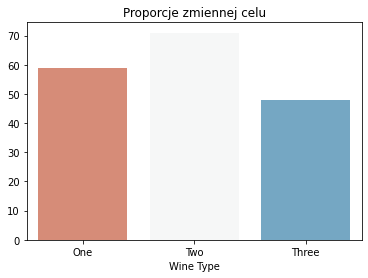

In [36]:
# sprawdzamy zbalansowanie zbioru
targetPlot(wine, 'Wine Type')

Nie ma dużego niezbalansowania, jednak jakieś ono jest, więc możemy się cieszyć, że nie na darmo daliśmy miary dobre dla wszystkich możliwości.

### Modelowanie

Skoro mamy zapisane zbiory treningowe i testowe w funkcjach, a większość rzeczy, które chcemy policzyć jest zamknięta w funkcje to ten rodział będzie ich wywoływaniem.

Najpierw sprawdźmy jak się ma skalowanie danych o winie w zależności od jąder SVC.

In [37]:
examineTransformingInfluence(svc_rbf, 'SVC with rbf kernel', balanced_accuracy)
examineTransformingInfluence(svc_linear, 'SVC with linear kernel', balanced_accuracy)
examineTransformingInfluence(svc_poly, 'SVC with poly kernel', balanced_accuracy)
examineTransformingInfluence(svc_sigmoid, 'SVC with sigmoid kernel', balanced_accuracy)

SVC with rbf kernel:
Średnia wyników bez transformacji: 0.6199, odchylenie standardowe: 0.0202
Średnia wyników po standaryzacji: 0.9768, odchylenie standardowe: 0.0244
SVC with linear kernel:
Średnia wyników bez transformacji: 0.9690, odchylenie standardowe: 0.0235
Średnia wyników po standaryzacji: 0.9682, odchylenie standardowe: 0.0314
SVC with poly kernel:
Średnia wyników bez transformacji: 0.6030, odchylenie standardowe: 0.0358
Średnia wyników po standaryzacji: 0.9634, odchylenie standardowe: 0.0262
SVC with sigmoid kernel:
Średnia wyników bez transformacji: 0.1507, odchylenie standardowe: 0.0781
Średnia wyników po standaryzacji: 0.9669, odchylenie standardowe: 0.0413


Ten zbiór zdecydowanie ma lepsze wyniki niż 1/3, a skalowanie zmienia (w niektórych przypadkach jak sigmoid drastycznie) wartości miar dla średnich kroswalidacji. Bez standaryzacji wyniki sigmoidalnego jądra 0.1507 a po niej wzrastają prawie do jedynki. Czyli wciąż tylko upewniamy się, że standaryzacja jest dobra i potrzebna (artykuł się nie mylił).

Jak poprzednio powtarzamy badanie na zbiorach testowych.

In [38]:
test_metrics_wine = dataModeling()
test_metrics_wine

,kernel SVC,MCC,balanced accuracy
0,rbf,0.431332,0.636364
1,rbf with standard scaler,0.957696,0.980392
2,linear,0.914500,0.950089
3,linear with standard scaler,0.914500,0.950089
4,poly,0.431332,0.636364
5,poly with standard scaler,0.957696,0.980392
6,sigmoid,-0.313911,0.090909
7,sigmoid with standard scaler,0.957527,0.969697


Wnioski takie same, wszędzie obserwujemy wzrost wyników po skalowaniu (jedynie przy liniowym jest brak zmiany). Najlepszym jądrem okazuje się wielomianowane na równi z gaussowskim.

Wyniki po skalowaniu są już bardzo dobre, ciekawe jak bardzo strojenie parametrów je poprawi. Na początek standaryzujemy dane na stałe.

In [0]:
# skalowanie danych już na stałe
std_scaler = preprocessing.StandardScaler()
data_train = std_scaler.fit_transform(data_train) 
data_test = std_scaler.transform(data_test)

Upewniliśmy się na obu zbiorach, że standaryzacja jest potrzeba przy SVM i należy ją wykonywać zawsze przed przystąpieniem do modelowania (czasem może jednak lepiej sprawdzić normalizację albo inne sposoby skalowania w zależności od danych).

### Strojenie hiperparametrów

Będziemy stroić parametry tak jak poprzednio - dla kilku jąder SVC.

In [44]:
dict_of_best_classifiers_wine = tuner(data_train, target_train)

SVC_rbf:
Best parameters are:
{'gamma': 0.010000000000000002, 'degree': 4, 'C': 1.51}
The score: 0.994444
SVC_linear:
Best parameters are:
{'gamma': 0.304, 'degree': 7, 'C': 9.81}
The score: 0.961111
SVC_poly:
Best parameters are:
{'gamma': 0.109, 'degree': 1, 'C': 8.81}
The score: 0.961111
SVC_sigmoid:
Best parameters are:
{'gamma': 0.010000000000000002, 'degree': 4, 'C': 1.51}
The score: 0.988889


Parametry sigmoid i rbf są zbliżone do defaultowych. Najlepszy wynik osiągnął rbf, ale reszta wcale nie ma gorszych wyników - wszystkie są ponad 0.95.

Sprawdźmy wyniki na zbiorze testowym:

In [45]:
# tworzymy pipeline z najlepszymy modelami
best_pipelines = [dict_of_best_classifiers_wine[i].best_estimator_ for i in dict_of_best_classifiers_wine.keys()]

# zwracamy wyniki w postaci ramki dla danych testowych
dataTestModeling(best_pipelines)

,kernel SVC,MCC,balanced accuracy
0,SVC_rbf,0.957696,0.980392
1,SVC_linear,0.914500,0.950089
2,SVC_poly,0.914500,0.950089
3,SVC_sigmoid,0.914500,0.950089


In [42]:
# dla porównania poprzednie wyniki
test_metrics_wine

,kernel SVC,MCC,balanced accuracy
0,rbf,0.431332,0.636364
1,rbf with standard scaler,0.957696,0.980392
2,linear,0.914500,0.950089
3,linear with standard scaler,0.914500,0.950089
4,poly,0.431332,0.636364
5,poly with standard scaler,0.957696,0.980392
6,sigmoid,-0.313911,0.090909
7,sigmoid with standard scaler,0.957527,0.969697


Strojenie parametrów pomogło tylko przy wielomianowym i sigmoidalnym jądrze. Wyniki liniowego i gaussowskiego się nie zmieniły po strojeniu. Jądro gaussowskie wciąż jest najlepsze. Dziwne jest to, że inne jądra osiągnęły identyczne wyniki, z początku myślałam, że to błąd, jednak ta sama funkcja obliczyła dla poprzedniego zbioru i wyniki się tam różniły, więc to raczej nie jest błąd a taki przypadek.

Krótko podsumowując zadanie:
* standaryzacja okazała się bardzo potrzebna do uzyskaniu dobrych wyników (szczególnie dla jądra sigmoidalnego)
* najlepszym jądrem dla tych zbiorów okazało się gaussowskie, które jest w domyślnym ustawienu